In [2]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf


In [3]:
data = yf.download(tickers = 'BTC-USD')[['Close']]
data.index = pd.DatetimeIndex(data.index.values, freq = data.index.inferred_freq)

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Close
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


## Plot Data To see the Trend 

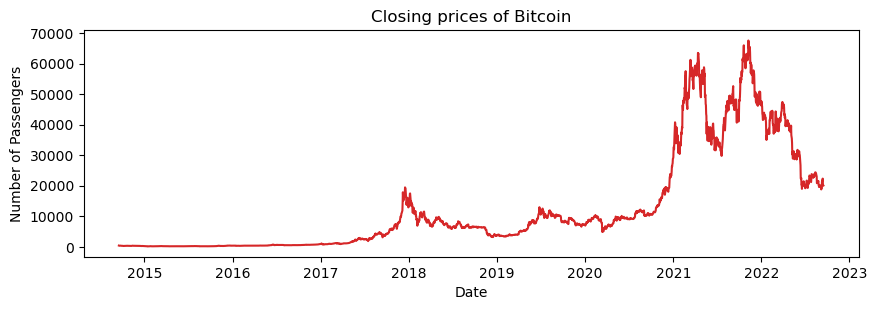

In [8]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x=data.index, y=data.Close, title='Closing prices of Bitcoin')

## Test for Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller, kpss

In [10]:
result=adfuller(data['Close'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.6640436610143257
p-value: 0.4497269319556338
Critial Values:
   1%, -3.432613179040485
Critial Values:
   5%, -2.8625399200643513
Critial Values:
   10%, -2.567302286065055


In [11]:
result = kpss(data, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 5.895837
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


## Transform non-stationary series into stationary


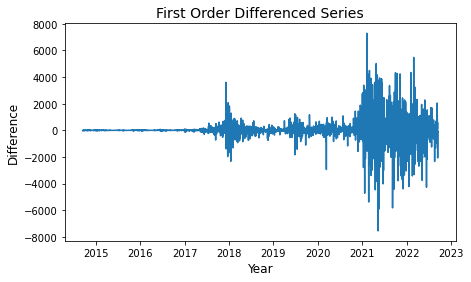

In [12]:
data1=data.copy()
data1["Close"] = data1['Close'].diff()
data1.dropna(inplace = True)

plt.figure(figsize=(7,4))
plt.plot(data1)
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Difference', fontsize=12)
plt.show()

In [13]:
data1

,Close
2014-09-18,-32.894012
2014-09-19,-29.644012
2014-09-20,14.108002
2014-09-21,-10.082977
2014-09-22,3.330994
...,...
2022-09-11,88.716797
2022-09-12,601.193359
2022-09-13,-2073.742188
2022-09-14,-55.617188


In [14]:
result = adfuller(data1.dropna())
print(result)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

(-8.97831727097374, 7.427241295223587e-15, 28, 2891, {'1%': -3.4326139625732837, '5%': -2.862540266114088, '10%': -2.5673024702995892}, 46837.984101512055)
ADF Test Statistic: -8.98
5% Critical Value: -2.86
p-value: 0.00


In [15]:
result = kpss(data1)
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.084490
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Test for autocorrelation


In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


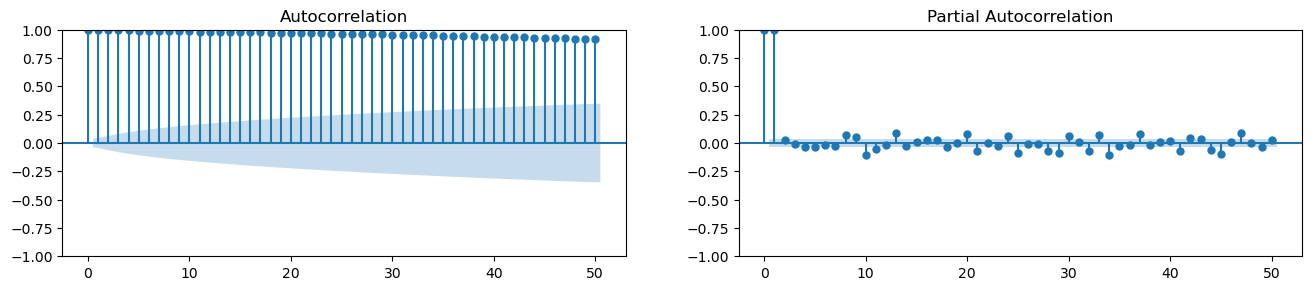

In [17]:
acf_50 = acf(data.Close, nlags=50)
pacf_50 = pacf(data.Close, nlags=50)

# Draw Plots
# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data.Close.tolist(), lags=50, ax=axes[0])
plot_pacf(data.Close.tolist(), lags=50, ax=axes[1])

plt.show()

## MA model

In [18]:
from statsmodels.tsa.arima.model import ARIMA


In [19]:
ma1 = ARIMA(data1, order = (0,0,1))
results_ma1 = ma1.fit()
print(results_ma1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2920
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -23676.066
Date:                Thu, 15 Sep 2022   AIC                          47358.133
Time:                        16:21:33   BIC                          47376.071
Sample:                    09-18-2014   HQIC                         47364.594
                         - 09-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7334     14.652      0.460      0.646     -21.984      35.451
ma.L1         -0.0260      0.010     -2.656      0.008      -0.045      -0.007
sigma2      6.469e+05   5547.652    116.610      0.0

In [20]:
ma2 = ARIMA(data1, order = (0,0,2))
results_ma2 = ma2.fit()
print(results_ma2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2920
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -23676.006
Date:                Thu, 15 Sep 2022   AIC                          47360.012
Time:                        16:21:41   BIC                          47383.929
Sample:                    09-18-2014   HQIC                         47368.627
                         - 09-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7334     14.797      0.455      0.649     -22.269      35.736
ma.L1         -0.0264      0.010     -2.695      0.007      -0.046      -0.007
ma.L2          0.0064      0.009      0.704      0.4

## AR model


In [24]:
model_ar2 = ARIMA(data1, order = (2,0,0))
results_ar2 = model_ar2.fit()
print(results_ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2920
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -23676.014
Date:                Thu, 15 Sep 2022   AIC                          47360.029
Time:                        16:23:02   BIC                          47383.946
Sample:                    09-18-2014   HQIC                         47368.644
                         - 09-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7334     14.758      0.456      0.648     -22.192      35.659
ar.L1         -0.0261      0.010     -2.676      0.007      -0.045      -0.007
ar.L2          0.0052      0.009      0.563      0.5

## ARMA model


In [25]:
model_arma22 = ARIMA(data1, order = (2,0,2))
results_arma22 = model_arma22.fit()
print(results_arma22.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2920
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -23663.135
Date:                Thu, 15 Sep 2022   AIC                          47338.270
Time:                        16:23:22   BIC                          47374.146
Sample:                    09-18-2014   HQIC                         47351.192
                         - 09-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7316     14.960      0.450      0.653     -22.590      36.054
ar.L1          0.8160      0.010     80.390      0.000       0.796       0.836
ar.L2         -0.9452      0.009   -100.821      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## ARIMA model

In [27]:
model_arima212 = ARIMA(data, order = (2,1,2))
results_arima212 = model_arima212.fit()
print(results_arima212.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2921
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -23662.708
Date:                Thu, 15 Sep 2022   AIC                          47335.416
Time:                        16:23:55   BIC                          47365.313
Sample:                    09-17-2014   HQIC                         47346.185
                         - 09-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9215      0.006   -347.219      0.000      -1.932      -1.911
ar.L2         -0.9718      0.005   -185.156      0.000      -0.982      -0.962
ma.L1          1.9265      0.006    321.492      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluate best model


In [28]:
models_name = ['MA1', 'MA2', 'AR2', 'ARMA','ARIMA']
results = [results_ma1,results_ma2,results_ar2,results_arma22,results_arima212]
from sklearn.metrics import mean_squared_error
rmse = []
for i in range(0, len(models_name)):
    if i != 4:
        r = mean_squared_error(y_true = data1, y_pred = results[i].predict(), squared=False)
        rmse.append(r)
    else:
        r = mean_squared_error(y_true = data, y_pred = results[i].predict(), squared=False)
        rmse.append(r)
        
rmse

[803.7616897965376,
 803.7439506512072,
 803.7476563017229,
 800.1616166933875,
 799.9497688956549]

In [29]:
aic = []
for i in range(0, len(models_name)):
    if i != 4:
        a = results[i].aic
        aic.append(a)
    else:
         a= results[i].aic
         aic.append(a) 
aic

[47358.13288540043,
 47360.011981451484,
 47360.02895751619,
 47338.269940256105,
 47335.416077104346]

In [30]:
results_rmse = list(zip(models_name,rmse))
summary = pd.DataFrame(results_rmse, columns=['models_name','rmse'])
summary['aic']=aic
summary

,models_name,rmse,aic
0,MA1,803.761690,47358.132885
1,MA2,803.743951,47360.011981
2,AR2,803.747656,47360.028958
3,ARMA,800.161617,47338.269940
4,ARIMA,799.949769,47335.416077


## Forecast


In [32]:

forecast = results_arima212.predict(start="2022-04-01", end="2022-08-30")

/var/folders/w_/wfsqzgp956n1415505gs36_h0000gn/T/ipykernel_66556/3566364604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = data.index
/var/folders/w_/wfsqzgp956n1415505gs36_h0000gn/T/ipykernel_66556/3566364604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Close']
/var/folders/w_/wfsqzgp956n1415505gs36_h0000gn/T/ipykernel_66556/3566364604.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

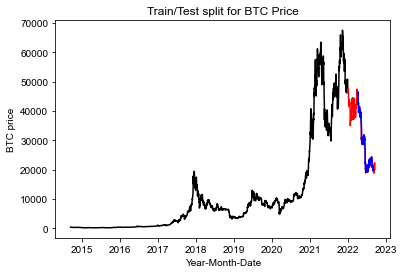

In [33]:

import seaborn as sns
data['Date'] = data.index
train = data[data['Date'] < pd.to_datetime("2021-12-31",format='%Y-%m-%d')]
train['train'] = train['Close']
del train['Date']
del train['Close']
test = data.loc[data['Date'] >= pd.to_datetime("2021-12-31", format='%Y-%m-%d')]
del test['Date']
test['test'] = test['Close']
del test['Close']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = 'blue')
plt.title("Train/Test split for BTC Price")
plt.ylabel("BTC price")
plt.xlabel("Year-Month-Date")
sns.set()
plt.show()